In [4]:
import os
from pathlib import Path
import io
import boto3
import requests
import torch
from pathlib import Path
from io import BytesIO
import json
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from pyproj import Transformer
import rasterio.features
import shapely.geometry
import numpy as np
from shapely.geometry import Polygon
import geopandas as gpd

1. Open patch tif files and extract meta data and serialize to json
2. Loop over directory and stop if a solar park is found
3. transform predicted mask to coordinates and calculate area
4. jsonify coordinnates, area and dates and send it to db/api

### 1. Open patch tif files and extract meta data and serialize to json

In [8]:
input_path = Path(r"C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\test_images_geotiff\33UVV_1_2023-5-13.tif")
image = rasterio.open(input_path).read()
metadata = rasterio.open(input_path).meta


In [7]:
metadata

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 256,
 'height': 256,
 'count': 4,
 'crs': CRS.from_epsg(32633),
 'transform': Affine(10.0, 0.0, 399960.0,
        0.0, -10.0, 6000000.0)}

In [10]:
headers = {'Content-Type': 'application/json'}
json_data = json.dumps(image.tolist())

In [11]:
req = requests.post("http://localhost:8080/predictions/test", headers=headers, data=json_data)
print(req)

<Response [200]>


In [12]:
pred = np.array(req.json())

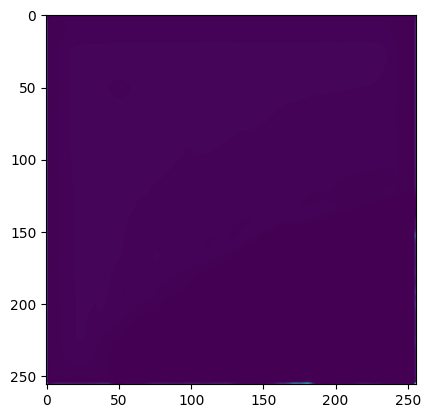

<Axes: >

In [14]:
show(pred)

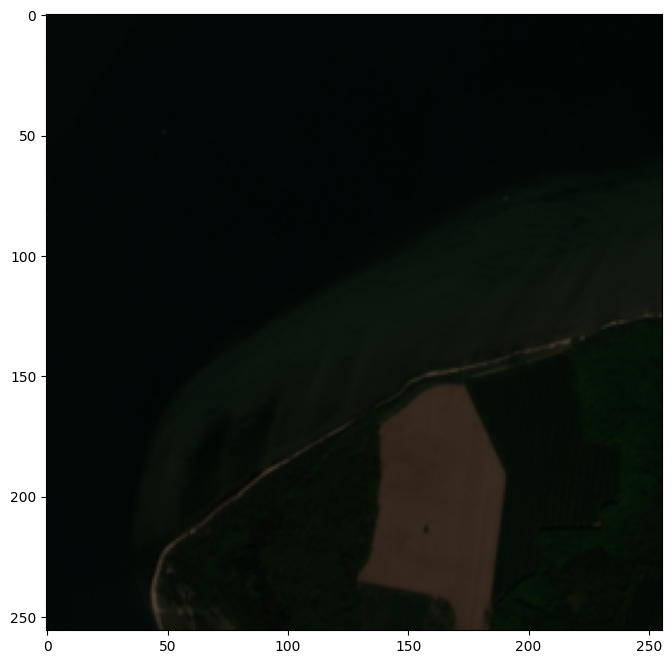

In [16]:
plt.figure(figsize=(8, 8))
plt.imshow(image[1:4,:,:].transpose(1,2,0))

### 2. Loop over directory and stop if a solar park is found

Solarpark detected
C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\test_images_geotiff\33UVV_1012_2023-5-13.tif


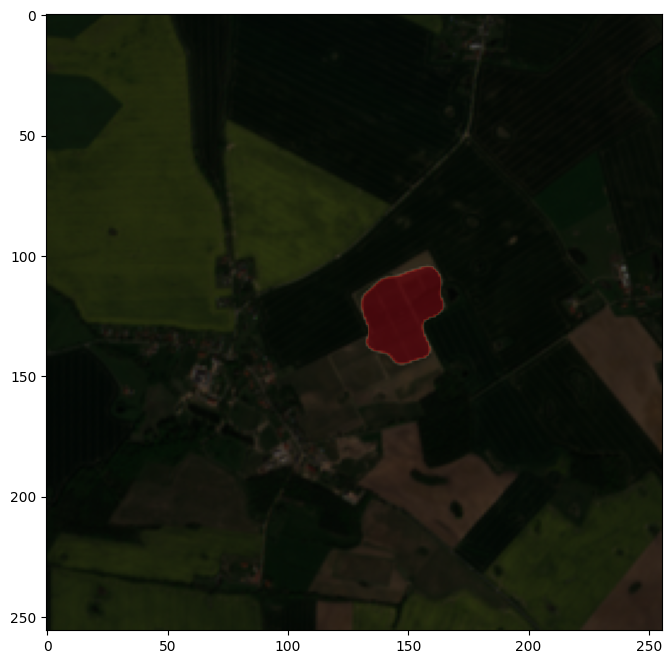

In [3]:
counter = 0
for i, file_path in enumerate(Path(r"C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\test_images_geotiff").glob("*.tif")):
    image = rasterio.open(file_path).read()
    metadata = rasterio.open(file_path).meta
    headers = {'Content-Type': 'application/json'}
    json_data = json.dumps(image.tolist())
    req = requests.post("http://localhost:6080/predictions/solar-park-detection", headers=headers, data=json_data)
    pred = np.array(req.json())
    if pred.sum() > 400:
        counter += 1
        if counter > 1:
            print("Solarpark detected")
            print(file_path)
            plt.figure(figsize=(8, 8))
            plt.imshow(image[1:4,:,:].transpose(1,2,0))
            plt.imshow(pred[0], alpha=0.6*pred[0], cmap="Reds")
            plt.show()
            break

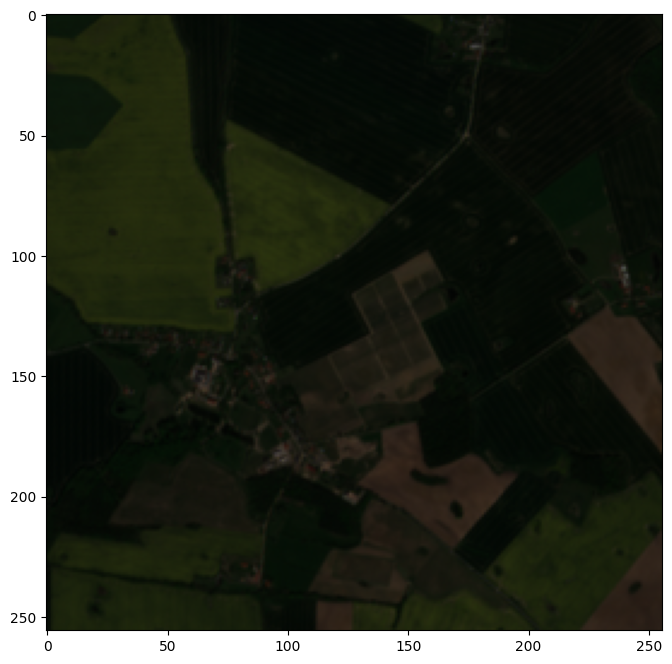

In [3]:
plt.figure(figsize=(8, 8))
plt.imshow(image[1:4,:,:].transpose(1,2,0))

In [25]:
pred[0].shape

(256, 256)

In [31]:
pred[0].sum()

542.373759455555

### 3. transform predicted mask to coordinates and calculate area

In [4]:
metadata

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 256,
 'height': 256,
 'count': 4,
 'crs': CRS.from_epsg(32633),
 'transform': Affine(10.0, 0.0, 407640.0,
        0.0, -10.0, 5938560.0)}

In [9]:
transform = metadata['transform']
crs = metadata['crs']
transformer = Transformer.from_crs(crs, "EPSG:4326", always_xy=True)

# convert to binary mask
pred_new = np.where(pred[0] < 0.5, 0, 1)

# extract shapes
shapes = rasterio.features.shapes(pred_new, transform=transform)

polygons = [Polygon(shape[0]["coordinates"][0]) for shape in shapes if shape[1] == 1]



for polygon in polygons:
    # calc area in m^2
    area = polygon.area
    
    # get exterior coordinates
    transformed_polygon = transformer.transform(polygon.exterior.xy[0], polygon.exterior.xy[1])

    lon_lat_polygon = list(zip(*transformed_polygon))

   


In [10]:
area

96600.0

In [11]:
lon_lat_polygon

[(13.628563311341024, 53.57857610278089),
 (13.629318270228392, 53.5785847558635),
 (13.629321177383186, 53.5784948960752),
 (13.629472168887746, 53.57849662611453),
 (13.629475075706848, 53.57840676631912),
 (13.629626066907097, 53.57840849616229),
 (13.629628973390506, 53.57831863635976),
 (13.629779964286449, 53.57832036600678),
 (13.62980902505771, 53.57742176784441),
 (13.62996001276944, 53.577423497244496),
 (13.629974540966915, 53.57697419808009),
 (13.629823554855069, 53.57697246870822),
 (13.62982646076748, 53.57688260887658),
 (13.629675474991293, 53.576880879319845),
 (13.629678381207988, 53.57679101949238),
 (13.62952739576746, 53.5767892897508),
 (13.629530302288435, 53.5766994299275),
 (13.6290773470209, 53.57669423957665),
 (13.629080254486084, 53.57660437976883),
 (13.628778285026128, 53.57660091859372),
 (13.6287986413224, 53.57597189997693),
 (13.628949623804816, 53.57597363062021),
 (13.628955439108285, 53.57579391099091),
 (13.629106420966496, 53.57579564143241),
 (

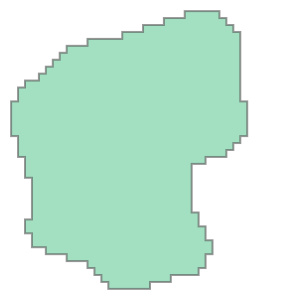

In [177]:
polygon

### 4. jsonify coordinnates, area and dates and send it to db/api

In [181]:
type(lon_lat_polygon)

list

In [190]:
type(area)

float

In [16]:
from datetime import date
data = {
  "size_in_sq_m": area,
  "peak_power": 0,
  "date_of_data": "2023-05-20",
  "first_detection": "2023-05-20",
  "last_detection": "2023-05-20",
  "geometry": "Test" # lon_lat_polygon
}
payload = {"context": json_data}
json_data = json.dumps(data)

In [13]:
json_data

'{"size_in_sq_m": 96600.0, "peak_power": 0, "date_of_data": "2023-05-20", "first_detection": "2023-05-20", "last_detection": "2023-05-20", "geometry": [[13.628563311341024, 53.57857610278089], [13.629318270228392, 53.5785847558635], [13.629321177383186, 53.5784948960752], [13.629472168887746, 53.57849662611453], [13.629475075706848, 53.57840676631912], [13.629626066907097, 53.57840849616229], [13.629628973390506, 53.57831863635976], [13.629779964286449, 53.57832036600678], [13.62980902505771, 53.57742176784441], [13.62996001276944, 53.577423497244496], [13.629974540966915, 53.57697419808009], [13.629823554855069, 53.57697246870822], [13.62982646076748, 53.57688260887658], [13.629675474991293, 53.576880879319845], [13.629678381207988, 53.57679101949238], [13.62952739576746, 53.5767892897508], [13.629530302288435, 53.5766994299275], [13.6290773470209, 53.57669423957665], [13.629080254486084, 53.57660437976883], [13.628778285026128, 53.57660091859372], [13.6287986413224, 53.57597189997693

In [290]:
import json

def is_json(myjson):
  try:
    json.loads(myjson)
  except ValueError as e:
    return False
  return True

is_json(json_data)

True

In [17]:
url = 'http://localhost:5000/api/v1/solarpark/'
headers = {"Content-type": "application/json"}
response = requests.post(url, headers=headers, json=data)
response

<Response [200]>

In [295]:
response.status_code

200

In [294]:
response.json()

{'size_in_sq_m': 0.0,
 'peak_power': 0.0,
 'date_of_data': '2023-05-20',
 'first_detection': '2023-05-20',
 'last_detection': '2023-05-20',
 'geometry': 'string6',
 'id_plant': 18}

In [289]:
response.request.body

In [275]:
response.request.headers

{'User-Agent': 'python-requests/2.29.0', 'Accept-Encoding': 'gzip, deflate', 'Accept': '*/*', 'Connection': 'keep-alive', 'Content-type': 'application/json', 'Content-Length': '118'}

In [276]:
response.request.url

'http://localhost:5000/solar_plants/'

In [213]:
url = 'http://localhost:6000/solarpark/1'
response = requests.get(url)

In [214]:
response.json()

{'size_in_sq_m': 0.0,
 'peak_power': 0.0,
 'date_of_data': '2023-05-20',
 'first_detection': '2023-05-20',
 'last_detection': '2023-05-20',
 'geometry': 'string',
 'id_plant': 1}

### 5. Whole process

In [28]:
def check_ml_online(url: str):
    while True:
        try:
            response = requests.get("http://localhost:8080/ping")
            if response.status_code == 200:
                print("TorchServe is running")
                break
            else:
                print("TorchServe is not running. retry in 5 seconds.")
                time.sleep(5)
        except requests.exceptions.ConnectionError:
            print("TorchServe is not running")
            time.sleep(5)


def send_to_ml_model(data_array: np.ndarray, metadata: dict) -> dict:
    headers = {"Content-Type": "application/json"}
    json_data = json.dumps(data_array.tolist())
    req = requests.post(
        "http://localhost:8080/predictions/solar-park-detection",
        headers=headers,
        data=json_data,
    )
    pred = np.array(req.json())
    mask = np.where(pred[0] < 0.5, 0, 1)
    if mask.sum() == 0:
        return {}
    else:
        print(f"Found prediction")
        return pred


def prediction_to_mask(prediction: np.ndarray) -> np.ndarray:
    return np.where(prediction[0] < 0.5, 0, 1)


def masks_to_polygons(masks: np.ndarray, metadata: dict) -> gpd.GeoDataFrame:
    masks = masks.astype(np.uint8)
    transform = metadata["transform"]
    crs = metadata["crs"]
    transformer = Transformer.from_crs(crs, "EPSG:4326", always_xy=True)
    # extract shapes
    shapes = rasterio.features.shapes(masks, transform=transform)
    #shapes = shapes.astype(np.uint8)
    return [Polygon(shape[0]["coordinates"][0]) for shape in shapes if shape[1] == 1]


def write_to_db(polygon: str) -> bool:
    data = {
        "size_in_sq_m": polygon.area,
        "peak_power": 0,
        "date_of_data": "2023-05-20",
        "first_detection": "2023-05-20",
        "last_detection": "2023-05-20",
        "geometry": polygon.wkt,
    }
    url = "http://localhost:8000/api/v1/solarpark/"
    headers = {"Content-type": "application/json"}
    print(f"Writing to DB: {data}")
    response = requests.post(url, headers=headers, json=data)
    return response.status_code

In [29]:
for i, file_path in enumerate(Path(r"C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\test_images_geotiff").glob("*.tif")):
    image = rasterio.open(file_path).read()
    metadata = rasterio.open(file_path).meta
    pred = send_to_ml_model(image, metadata)
    if len(pred) == 0:
        continue
    # mask = prediction_to_mask(pred)
    polygons = masks_to_polygons(pred, metadata)
    print(f"Found {len(polygons)} polygons")
    for polygon in polygons:
        write_to_db(polygon)

Found prediction
Found 0 polygons
Found prediction
Found 0 polygons
Found prediction
Found 0 polygons
Found prediction
Found 2 polygons
Writing to DB: {'size_in_sq_m': 2800.0, 'peak_power': 0, 'date_of_data': '2023-05-20', 'first_detection': '2023-05-20', 'last_detection': '2023-05-20', 'geometry': 'POLYGON ((501650 5938770, 501700 5938770, 501700 5938720, 501650 5938720, 501650 5938730, 501640 5938730, 501640 5938760, 501650 5938760, 501650 5938770))'}
Writing to DB: {'size_in_sq_m': 16700.0, 'peak_power': 0, 'date_of_data': '2023-05-20', 'first_detection': '2023-05-20', 'last_detection': '2023-05-20', 'geometry': 'POLYGON ((501810 5938730, 501840 5938730, 501840 5938720, 501850 5938720, 501850 5938710, 501860 5938710, 501860 5938680, 501850 5938680, 501850 5938670, 501840 5938670, 501840 5938650, 501830 5938650, 501830 5938630, 501820 5938630, 501820 5938590, 501810 5938590, 501810 5938580, 501710 5938580, 501710 5938590, 501670 5938590, 501670 5938600, 501660 5938600, 501660 5938610

In [ ]:
from typing import List, Tuple, Union
from pydantic.dataclasses import dataclass

@dataclass
class Geometry:
    type: str
    coordinates: List[Union[Tuple[float, float], Tuple[float, float, float]]]

Geometry(type='Polygon', coordinates=[[0, 0], [10, 10], [10, 0, 0.5]])

Geometry(type='Polygon', coordinates=[(0.0, 0.0), (10.0, 10.0), (10.0, 0.0, 0.5)])

In [ ]:
from shapely.geometry import Polygon
polygon = Polygon([(0, 0), (10, 10), (10, 0,)])

In [ ]:
type(polygon)

shapely.geometry.polygon.Polygon

In [ ]:
from pydantic import validator
@validator('name', pre=True)
def name_must_be_str(cls, v):
    if type(v) is not str:
        raise TypeError("'name' must be str, not " + type(v).__name__)
    return v

In [ ]:
from pydantic import BaseModel, ValidationError, validator
class Val_Polygon(str):
    @classmethod
    def __get_validators__(cls):
        # one or more validators may be yielded which will be called in the
        # order to validate the input, each validator will receive as an input
        # the value returned from the previous validator
        yield cls.validate
        
    def __init__(self, name: str):
        self.name = name

class Solarpark(BaseModel):
    model_config = dict(arbitrary_types_allowed=True)
    size_in_sq_m: float
    geometry: Polygon

    @validator('geometry', pre=True)
    def geometry_must_be_polygon(cls, v):
        if type(v) is not Polygon:
            raise TypeError("'geometry' must be Polygon, not " + type(v).__name__)
        return v

RuntimeError: no validator found for <class 'shapely.geometry.polygon.Polygon'>, see `arbitrary_types_allowed` in Config

In [ ]:
solarpark = Solarpark(size_in_sq_m=15.23, geometry=polygon)

ValidationError: 1 validation error for Solarpark
geometry
  'geometry' must be Polygon, not Polygon (type=type_error)

In [ ]:
Polygon('POLYGON ((0 0, 10 10, 10 0, 0 0))')

## Old code below

In [ ]:
transform[0]

10.0

In [ ]:
from functools import partial

transform = metadata['transform']
pixel_to_coords = partial(rasterio.transform.xy, transform)

In [ ]:
pixel_to_coords

functools.partial(<function xy at 0x0000026EDEA7C1F0>, Affine(10.0, 0.0, 407640.0,
       0.0, -10.0, 5938560.0))

In [ ]:
# Finde die Koordinaten der Ecken der Maske
rows, cols = np.where(pred[0])
x_coords, y_coords = pixel_to_coords(cols, rows)

In [ ]:
from shapely.geometry import Polygon
# Erstelle ein Polygon aus den Koordinaten
polygon = Polygon(zip(x_coords, y_coords))

In [ ]:
polygon.wkt

'POLYGON ((407645 5938555, 407645 5938545, 407645 5938535, 407645 5938525, 407645 5938515, 407645 5938505, 407645 5938495, 407645 5938485, 407645 5938475, 407645 5938465, 407645 5938455, 407645 5938445, 407645 5938435, 407645 5938425, 407645 5938415, 407645 5938405, 407645 5938395, 407645 5938385, 407645 5938375, 407645 5938365, 407645 5938355, 407645 5938345, 407645 5938335, 407645 5938325, 407645 5938315, 407645 5938305, 407645 5938295, 407645 5938285, 407645 5938275, 407645 5938265, 407645 5938255, 407645 5938245, 407645 5938235, 407645 5938225, 407645 5938215, 407645 5938205, 407645 5938195, 407645 5938185, 407645 5938175, 407645 5938165, 407645 5938155, 407645 5938145, 407645 5938135, 407645 5938125, 407645 5938115, 407645 5938105, 407645 5938095, 407645 5938085, 407645 5938075, 407645 5938065, 407645 5938055, 407645 5938045, 407645 5938035, 407645 5938025, 407645 5938015, 407645 5938005, 407645 5937995, 407645 5937985, 407645 5937975, 407645 5937965, 407645 5937955, 407645 593794

In [ ]:
from pyproj import Transformer
transformer = Transformer.from_crs(crs, "EPSG:4326", always_xy=True)

In [ ]:
transformed_polygon = transformer.transform(polygon.exterior.xy[0], polygon.exterior.xy[1])

In [ ]:
lon_lat_polygon = list(zip(*transformed_polygon))
len(lon_lat_polygon)

65537

In [ ]:
from functools import partial
from shapely.geometry import Polygon
from pyproj import Transformer
from pyproj import CRS

transform = metadata['transform']
crs = metadata['crs']

pixel_to_coords = partial(rasterio.transform.xy, transform)
# Find the coordinates of the corners of the mask
rows, cols = np.where(pred[0])
x_coords, y_coords = pixel_to_coords(cols, rows)

# Create a polygon from the coordinates
polygon = Polygon(zip(x_coords, y_coords))


transformer = Transformer.from_crs(crs, "EPSG:4326", always_xy=True)

transformed_polygon = transformer.transform(polygon.exterior.xy[0], polygon.exterior.xy[1])

lon_lat_polygon = list(zip(*transformed_polygon))
#print(lon_lat_polygon)

dst_crs = CRS.from_epsg(3857)
# Definiere die Transformationsfunktion
#area_transformer = Transformer.from_crs(crs, dst_crs)

# Transformiere das Polygon in das Zielkoordinatensystem
#
# area_transformed_polygon = area_transformer.transform(transformer.transform, Polygon(polygon))

# Berechne die Fläche des Polygons in Quadratmetern
# area = transformed_polygon.area
# print(area)

TypeError: input must be a scalar

In [ ]:
from functools import partial
from shapely.geometry import Polygon
from pyproj import Transformer
from pyproj import CRS

transform = metadata['transform']
crs = metadata['crs']

pixel_to_coords = partial(rasterio.transform.xy, transform)
# Find the coordinates of the corners of the mask
pred_new = np.where(pred[0] < 0.5, 0, 1)
rows, cols = np.where(pred_new)

x_coords, y_coords = pixel_to_coords(cols, rows)

# Create a polygon from the coordinates
polygon = Polygon(zip(x_coords, y_coords))


transformer = Transformer.from_crs(crs, "EPSG:4326", always_xy=True)

transformed_polygon = transformer.transform(polygon.exterior.xy[0], polygon.exterior.xy[1])

lon_lat_polygon = list(zip(*transformed_polygon))
lon_lat_polygon


[(13.62108886120047, 53.573860674841505),
 (13.621091785302221, 53.573770815291816),
 (13.621094709388188, 53.57368095574068),
 (13.621097633458373, 53.57359109618805),
 (13.621100557512774, 53.57350123663396),
 (13.621231064233633, 53.57413199382482),
 (13.621233988062825, 53.57404213427387),
 (13.621236911876231, 53.57395227472144),
 (13.621239835673856, 53.57386241516756),
 (13.621242759455702, 53.57377255561219),
 (13.621245683221764, 53.57368269605536),
 (13.621248606972044, 53.57359283649707),
 (13.621251530706543, 53.57350297693729),
 (13.62125445442526, 53.573413117376056),
 (13.62137326906002, 53.574403312638516),
 (13.62137619261664, 53.57431345308628),
 (13.62137911615748, 53.574223593532594),
 (13.621382039682537, 53.574133733977426),
 (13.621384963191813, 53.574043874420795),
 (13.62138788668531, 53.57395401486269),
 (13.621390810163028, 53.57386415530312),
 (13.621393733624965, 53.573774295742076),
 (13.621396657071122, 53.57368443617957),
 (13.621399580501498, 53.5735945

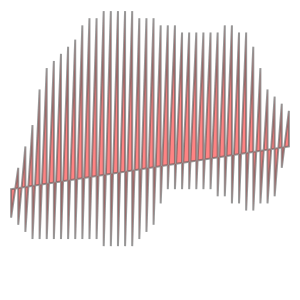

In [ ]:
polygon

In [ ]:
simplified_polygon = polygon.simplify(200)

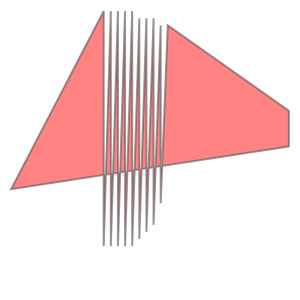

In [ ]:
simplified_polygon

In [ ]:
import rasterio.features
import shapely.geometry
import numpy as np
shapes = rasterio.features.shapes(pred_new, transform=transform)

In [ ]:
# for multi-polygons
polygons = [Polygon(shape[0]["coordinates"][0]) for shape in shapes if shape[1] == 1]

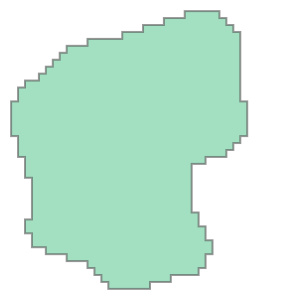

In [ ]:
# get first polygon
polygons[0]

In [ ]:
area =polygons[0].area
print(area)

96600.0


In [ ]:
import numpy as np

# Create a binary array with 1's inside and 0's outside
binary_array = np.zeros((10, 10))
binary_array[2:8, 2:8] = 1

# Pad the array with zeros on all sides
padded_array = np.pad(binary_array, pad_width=1, mode='constant')

# Compute the differences between adjacent elements along each axis
diff_x = np.diff(padded_array, axis=1)
diff_y = np.diff(padded_array, axis=0)

# Find the indices of the 1's in the difference arrays
indices_x = np.where(diff_x != 0)
indices_y = np.where(diff_y != 0)

# Combine the indices into a single array
frontier = np.column_stack((indices_x[1], indices_x[0]))
frontier = np.concatenate((frontier, np.column_stack((indices_y[1], indices_y[0]))))

print(frontier)

[[2 3]
 [8 3]
 [2 4]
 [8 4]
 [2 5]
 [8 5]
 [2 6]
 [8 6]
 [2 7]
 [8 7]
 [2 8]
 [8 8]
 [3 2]
 [4 2]
 [5 2]
 [6 2]
 [7 2]
 [8 2]
 [3 8]
 [4 8]
 [5 8]
 [6 8]
 [7 8]
 [8 8]]


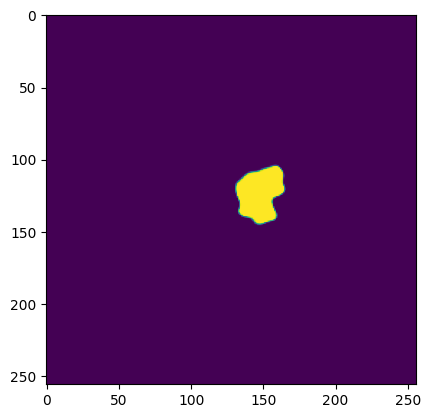

<Axes: >

In [ ]:
show(pred[0])

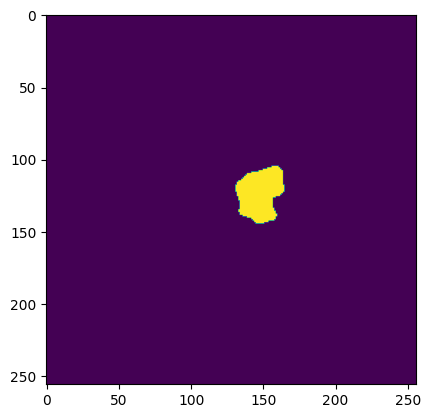

<Axes: >

In [ ]:
show(pred_new)

In [ ]:
from pyproj import Geod
# specify a named ellipsoid
geod = Geod(ellps="WGS84")
area_m2 = geod.geometry_area_perimeter(polygon)[0]
print('# Geodesic area: {:.3f} m^2'.format(area_m2))

# Geodesic area: nan m^2


In [ ]:

lon_lat_coords = list(polygon.exterior.coords)

utm_coords = transformer.transform(lon_lat_coords)

utm_polygon = Polygon(utm_coords)

# Berechnen Sie die Fläche des Polygons in Quadratmetern
area = utm_polygon.area
area

TypeError: Transformer.transform() missing 1 required positional argument: 'yy'

In [ ]:
crs_geographic = CRS("EPSG:4326")
crs_utm = CRS("EPSG:32632")  # UTM zone 32N

# Erstellen Sie den Transformer
transformer = Transformer.from_crs(crs_geographic, crs_utm, always_xy=True)

# Transformieren Sie das Polygon in die UTM-Projektion
x_coords, y_coords = polygon.exterior.xy
utm_x_coords, utm_y_coords = transformer.transform(x_coords, y_coords)

utm_polygon = Polygon(zip(utm_x_coords, utm_y_coords))

In [ ]:
area = utm_polygon.area

c:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\.venv\lib\site-packages\shapely\measurement.py:45: RuntimeWarning: invalid value encountered in area
  return lib.area(geometry, **kwargs)


In [ ]:
area

nan

In [ ]:
polygon.wkt

'POLYGON ((408695 5936995, 408695 5936985, 408695 5936975, 408695 5936965, 408695 5936955, 408705 5937025, 408705 5937015, 408705 5937005, 408705 5936995, 408705 5936985, 408705 5936975, 408705 5936965, 408705 5936955, 408705 5936945, 408715 5937055, 408715 5937045, 408715 5937035, 408715 5937025, 408715 5937015, 408715 5937005, 408715 5936995, 408715 5936985, 408715 5936975, 408715 5936965, 408715 5936955, 408715 5936945, 408715 5936935, 408725 5937085, 408725 5937075, 408725 5937065, 408725 5937055, 408725 5937045, 408725 5937035, 408725 5937025, 408725 5937015, 408725 5937005, 408725 5936995, 408725 5936985, 408725 5936975, 408725 5936965, 408725 5936955, 408725 5936945, 408725 5936935, 408725 5936925, 408735 5937135, 408735 5937125, 408735 5937115, 408735 5937105, 408735 5937095, 408735 5937085, 408735 5937075, 408735 5937065, 408735 5937055, 408735 5937045, 408735 5937035, 408735 5937025, 408735 5937015, 408735 5937005, 408735 5936995, 408735 5936985, 408735 5936975, 408735 593696

In [ ]:
len(lon_lat_polygon)

967

In [ ]:
simplified_polygon = polygon.simplify(0.5)


In [ ]:
simplified_polygon.length

1306661.2445648198

In [ ]:
mask = pred.astype(np.uint16)
shapes = rasterio.features.shapes(mask, transform=transform)
shapes

<generator object shapes at 0x0000026EE43121F0>

In [ ]:
geometries = rasterio.features.shapes(mask, transform=transform)
# Erstelle ein Polygon aus den Geometrien
polygon = Polygon([shape[0] for shape in geometries])
polygon

ValueError: could not convert string to float: 'type'

In [ ]:
# alternative Lösung:
from rasterio.features import geometry_mask
polygon = geometry_mask(shapes, transform=transform,out_shape=pred[0].shape, invert=True)

ValueError: No valid geometry objects found for rasterize

In [ ]:
transform = metadata['transform']
crs = metadata['crs']
# Wandle die Pixelkoordinaten der Maske in Koordinaten um
coords = rasterio.transform.xy(transform, rows=np.arange(pred.shape[0]), cols=np.arange(pred.shape[1]))
lonlat_coords = rasterio.transform.xy(rasterio.crs.CRS.from_epsg(4326), crs, coords[0], coords[1])

KeyError: 0

In [ ]:
coords[0]

[407645.0,
 407655.0,
 407665.0,
 407675.0,
 407685.0,
 407695.0,
 407705.0,
 407715.0,
 407725.0,
 407735.0,
 407745.0,
 407755.0,
 407765.0,
 407775.0,
 407785.0,
 407795.0,
 407805.0,
 407815.0,
 407825.0,
 407835.0,
 407845.0,
 407855.0,
 407865.0,
 407875.0,
 407885.0,
 407895.0,
 407905.0,
 407915.0,
 407925.0,
 407935.0,
 407945.0,
 407955.0,
 407965.0,
 407975.0,
 407985.0,
 407995.0,
 408005.0,
 408015.0,
 408025.0,
 408035.0,
 408045.0,
 408055.0,
 408065.0,
 408075.0,
 408085.0,
 408095.0,
 408105.0,
 408115.0,
 408125.0,
 408135.0,
 408145.0,
 408155.0,
 408165.0,
 408175.0,
 408185.0,
 408195.0,
 408205.0,
 408215.0,
 408225.0,
 408235.0,
 408245.0,
 408255.0,
 408265.0,
 408275.0,
 408285.0,
 408295.0,
 408305.0,
 408315.0,
 408325.0,
 408335.0,
 408345.0,
 408355.0,
 408365.0,
 408375.0,
 408385.0,
 408395.0,
 408405.0,
 408415.0,
 408425.0,
 408435.0,
 408445.0,
 408455.0,
 408465.0,
 408475.0,
 408485.0,
 408495.0,
 408505.0,
 408515.0,
 408525.0,
 408535.0,
 408545.0,

In [ ]:
# get image:
img_path = r"C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\test_images_geotiff2\image_0_4.tif"
img_path = Path(img_path)
image = rasterio.open(img_path)

In [ ]:
# login to aws
session = boto3.Session(
    aws_access_key_id=os.getenv("aws_access_key_id"),
    aws_secret_access_key=os.getenv("aws_secret_access_key"),
    region_name=os.getenv("region_name"),
)

# crreate s3 client
s3_client = session.client("s3")

bucket_name = os.getenv("aws_s3_bucket")

In [ ]:
prefix = "data_preprocessed"
img_name = "33UVV_1002_2023-5-13.tif"
response = s3_client.get_object(Bucket=bucket_name, Key=f"{prefix}/{img_name}")

In [ ]:
response["Metadata"]

{}

In [ ]:
# needs to install rasterio[s3] first
# produces a lot of requests to aws (only 2000 are free per month)
# https://rasterio.readthedocs.io/en/stable/topics/vsi.html#aws-s3
with rasterio.open('s3://solar-detection-697553-eu-central-1/data_preprocessed/33UVV_1002_2023-5-13.tif') as src:
    array = src.read()
    profile = src.profile

c:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\.venv\lib\site-packages\rasterio\__init__.py:321: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [ ]:
array.shape

(4, 256, 256)

Alternative:

In [ ]:
file_name = "33UVV_1002_2023-5-13.tif"
folder = Path("data_preprocessed")
folder.mkdir(parents=True, exist_ok=True)
response_content = response["Body"].read()
with open(folder/ file_name, "wb") as file:
    file.write(response_content)

In [ ]:
with rasterio.open(folder / file_name) as src:
    array = src.read()
    metadata= src.meta
    

c:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\.venv\lib\site-packages\rasterio\__init__.py:321: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [ ]:
metadata

{'driver': 'JP2OpenJPEG',
 'dtype': 'uint16',
 'nodata': None,
 'width': 256,
 'height': 256,
 'count': 4,
 'crs': None,
 'transform': Affine(1.0, 0.0, 0.0,
        0.0, 1.0, 0.0)}

In [ ]:
headers = {'Content-Type': 'application/json'}
json_data = json.dumps(r"C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\src\ml-feeder\app\data_preprocessed\33UVV_1002_2023-5-13.tif")

In [ ]:
json_data = json.dumps(array.tolist())

In [ ]:
req = requests.post("http://localhost:8080/predictions/test", headers=headers, data=json_data)
print(req)

<Response [200]>


In [ ]:
pred = np.array(req.json())

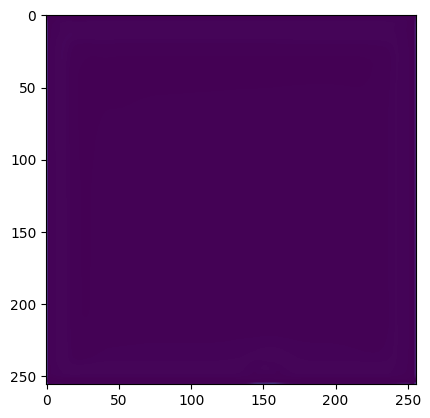

<Axes: >

In [ ]:
show(pred)

In [ ]:
array.shape

(4, 256, 256)

Alternative, direclty to json:

In [ ]:
bytes_data = response['Body'].read()

In [ ]:
bytes_io = io.BytesIO(bytes_data)

In [ ]:
json_obj = {
    'geotiff': bytes_data.decode('utf-8', 'ignore').encode('base64').decode('utf-8', 'ignore')
}

# Konvertiere das JSON-Objekt in einen JSON-String
json_str = json.dumps(json_obj)

LookupError: 'base64' is not a text encoding; use codecs.encode() to handle arbitrary codecs

In [ ]:
json_data = json.dumps(io.BytesIO(bytes_data))

AttributeError: '_io.BytesIO' object has no attribute 'tolist'

In [ ]:
type(bytes_data)

bytes

In [ ]:
type(io.BytesIO(bytes_data))

_io.BytesIO

In [ ]:
tmp

In [ ]:
image.shape

(256, 256)

In [ ]:
im_numpy = img_tensor.numpy()
headers = {'Content-Type': 'application/json'}
image = rasterio.open(img_path)
json_data = json.dumps(r"C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\test_images_geotiff2\image_0_4.tif")
img_tensor = torch.load(im_numpy.tolist())

In [ ]:
req = requests.post("http://localhost:8080/predictions/test", headers=headers, data=json_data)
print(req)

<Response [200]>


In [ ]:
pred = np.array(req.json())

In [ ]:
pred.squeeze(0).shape

(256, 256)

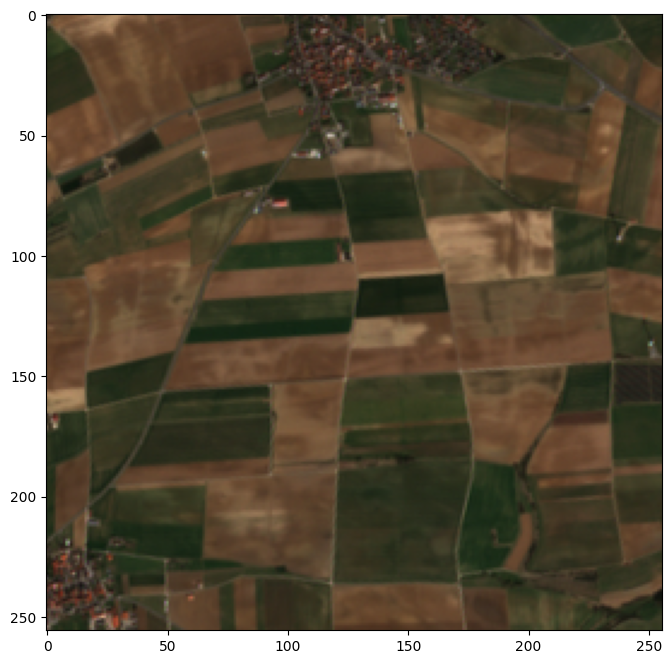

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(torch.Tensor.numpy(img_tensor[1:4,:,:]).transpose((1,2,0)))

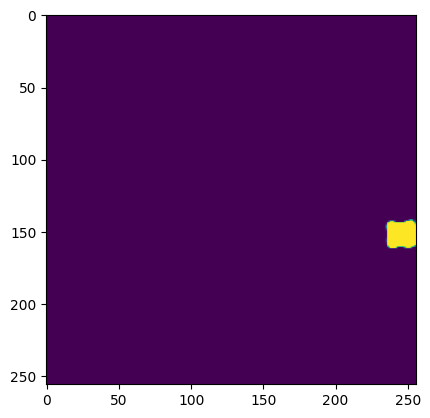

<Axes: >

In [ ]:
show(pred)

In [ ]:
mask_path = Path(r"C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\test_mask_patches\mask_0_3.tif")

mask = rasterio.open(mask_path)


In [ ]:
mask.meta

{'driver': 'JP2OpenJPEG',
 'dtype': 'uint16',
 'nodata': None,
 'width': 256,
 'height': 256,
 'count': 1,
 'crs': CRS.from_epsg(32632),
 'transform': Affine(10.0, 0.0, 707640.0,
        0.0, -10.0, 5800020.0)}

In [ ]:
mask_open = mask.read()

In [ ]:
mask_open.sum()

0

In [ ]:
image_path = Path(r"C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\test_images_geotiff\33UVV_4_2023-5-13.tif")
image = rasterio.open(image_path)

In [ ]:
image.meta

{'driver': 'JP2OpenJPEG',
 'dtype': 'uint16',
 'nodata': None,
 'width': 256,
 'height': 256,
 'count': 4,
 'crs': CRS.from_epsg(32633),
 'transform': Affine(10.0, 0.0, 407640.0,
        0.0, -10.0, 6000000.0)}

In [ ]:
image_open = image.read()

In [ ]:
image_open.shape

(4, 256, 256)

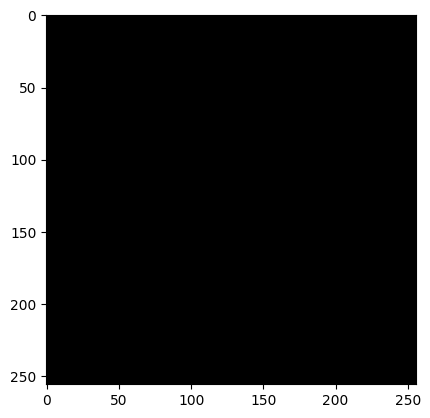

<Axes: >

In [ ]:
show(image_open[1:4,:,:])